In [10]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install memory_profiler

In [12]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [13]:
!pip install -q git+git://github.com/quantumjot/BayesianTracker.git
!pip install -q git+git://github.com/quantumjot/cellx.git

!pip install umap-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [1]:
import numpy as np
import random as rand

In [2]:
# if error message: re-run one more time 
# (seems to produce an error on every 1st run but not on the 2nd)
from umap import UMAP

ModuleNotFoundError: No module named 'umap'

In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [17]:
import tensorflow as tf
import tensorflow.keras as K

In [18]:
from tensorflow.keras.applications import ResNet50

In [19]:
from btrack.dataio import HDF5FileHandler
from cellx.tools.projection import ManifoldProjection2D


In [46]:
# personalized
from scipy.stats import binned_statistic_2d
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

def _load_and_normalize(filename: str, output_shape: tuple = (64, 64)):
    """Load an image, reshape to output_shape and normalize."""

    # reshape to a certain image size
    image = resize(imread(filename), output_shape, preserve_range=True)
    n_pixels = np.prod(output_shape)
    n_channels = image.shape[-1]
    print(f"channels: {n_channels}")

    a_std = lambda d: np.max([np.std(d), 1.0 / np.sqrt(n_pixels)])
    nrm = lambda d: np.clip((d - np.mean(d)) / a_std(d), -4.0, 4.0)

    for dim in range(n_channels):
        image[..., dim] = nrm(image[..., dim])

    # TODO(arl): ????
    image = np.clip(255.0 * ((image + 1.0) / 5.0), 0, 255)
    return image


class MyManifoldProjection2D:
    """ManifoldProjection2D.

    Make a montage of image patches that represent examples from a manifold
    projection.

    Parameters
    ----------
    images : list of str or (N, W, H, C) np.ndarray
        A list of image filenames or a numpy array of N images, width W, height
        H, and C channels.
    output_shape : tuple of int
        Final size to reshape individual image patches to for the montage.
    preload_images : bool
        Preload images if a list of image filenames is provided, or not.
    """

    def __init__(
        self, images: list, output_shape: tuple = (64, 64), preload_images: bool = True,
    ):

        self._output_shape = output_shape
        self._images = None

        # check if `images` parameter is a list of strings or a numpy array
        # to preload images, or not
        if all([isinstance(img, str) for img in images]):
            if preload_images:
                self._images = [self._get_image(file) for file in tqdm(images)]
        else:
            if not isinstance(images, np.ndarray):
                raise ValueError("Image type unknown.")
            self._images = images

    def _get_image(self, filename: str) -> np.ndarray:
        """Grab an image and resize it."""
        return _load_and_normalize(filename, output_shape=self._output_shape)

    def __call__(
        self, manifold: np.ndarray, bins: int = 32, components: tuple = (0, 1)
    ) -> tuple:
        """Build the projection.

        Parameters
        ----------
        manifold : np.ndarray
            Numpy array of the manifold projection.
        bins : int
            Number of two-dimensional bins to group the manifold examples in.
        components : tuple of int
            Dimensions of manifold to use when creating the projection.

        Returns
        -------
        imgrid : np.ndarray
            An image with example image patches from the manifold arranged on a
            grid.
        extent : tuple
            Delimits the minimum and maximum bin edges, in each dimension, used
            to create the result.
        """

        assert manifold.shape[0] == len(self._images)

        # bin the manifold
        counts, xe, ye, bn = binned_statistic_2d(
            manifold[:, components[0]],
            manifold[:, components[1]],
            [],
            bins=bins,
            statistic="count",
            expand_binnumbers=True,
        )

        bxy = zip(bn[0, :].tolist(), bn[1, :].tolist())

        # make a lookup dictionary
        grid = {}
        for idx, b in enumerate(bxy):
            if b not in grid:
                grid[b] = []

            if self._images is not None:
                grid[b].append(self._images[idx])
            else:
                if not grid[b]:
                    grid[b].append(self._get_image(self._image_files[idx]))

        # now make the grid image
        full_bins = [int(b) for b in self._output_shape]
        half_bins = [b // 2 for b in self._output_shape]
        imgrid = np.zeros(
            (
                (full_bins[0] + 1) * bins + half_bins[0],
                (full_bins[1] + 1) * bins + half_bins[1],
                3,
            ),
            dtype="uint16",
        )
        # build it
        for e, (xy, images) in enumerate(tqdm(grid.items())):
            stack = np.stack(images, axis=0)
            # get average of each stack of images -> average image generated
            # im = np.mean(stack, axis=0)
            # get random single image from stack
            rand.seed(e)
            rnd_pos = rand.randint(0, len(stack)-1)
            im = stack[rnd_pos, ...]

            xx, yy = xy
            blockx = slice(
                xx * full_bins[0] - half_bins[0],
                xx * full_bins[0] - half_bins[0] + self._output_shape[0],
                1,
            )
            blocky = slice(
                yy * full_bins[1] - half_bins[1],
                yy * full_bins[1] - half_bins[1] + self._output_shape[1],
                1,
            )

            try:
                imgrid[blockx, blocky] = im
            except:
                raise ValueError("`imgrid` error")
                pass
            
        # switch `xe` and `ye` around to get the right xy axes on the projection 
        extent = (min(ye), max(ye), min(xe), max(xe))
        print(extent)

        return imgrid, counts, extent

In [21]:
# image normalization for resnet inference
def normalize_image_array(img):
    img_mean = np.mean(img)
    img_stddev = max(np.std(img), 1.0/np.size(img))
    img = np.subtract(img, img_mean)
    img = np.divide(img, img_stddev)
    # clip to 4 standard deviations
    img = np.clip(img, -4, 4)
    return img

In [22]:
# resnet input: needs 3 channels
INPUT_SHAPE = (76, 76, 3)

In [23]:
# fpaths

# images .npy arrays with shape (n_images, INPUT_SHAPE[0], INPUT_SHAPE[1])
rois_path = "/content/drive/MyDrive/PhD/wt_data/set_n20_rois.npy"
mrois_path = "/content/drive/MyDrive/PhD/wt_data/set_n20_masked_rois.npy"
gmrois_path = "/content/drive/MyDrive/PhD/wt_data/set_n20_gauss_masked_rois.npy"

# image info .npy arrays
flags_path = "/content/drive/MyDrive/PhD/wt_data/set_n20_flags.npy"
labels_path = "/content/drive/MyDrive/PhD/wt_data/set_n20_labels.npy"

# export
export_path = "/content/drive/MyDrive/PhD/export_data/" 

# btrack tracks
h5_path = "/content/drive/MyDrive/PhD/wt_data/20190925_1_1-05_Les1_tracks.h5"

In [24]:
# get pre-trained resnet
model = ResNet50(
    include_top=False, # exclude final fully-connected layer
    weights="imagenet",
    input_shape=INPUT_SHAPE,
)

94773248/94765736 [==============================] - 1s 0us/step


In [25]:
# model.summary()

In [26]:
# load .npy as memmaps to avoid RAM overload
rois = np.load(rois_path, mmap_mode="c")
masked_rois = np.load(mrois_path, mmap_mode="c")
gauss_masked_rois = np.load(gmrois_path, mmap_mode="c")

edge_flags = np.load(flags_path, mmap_mode="r")
labels = np.load(labels_path, mmap_mode="r")

In [27]:
print(rois.dtype, type(rois), rois.shape)

uint16 <class 'numpy.memmap'> (191784, 76, 76)



**if using labels & flags (True = non-centered cell, with 0 padding)**

In [ ]:
# check class balance: dumbbells vs. non-dumbbells
print(len(np.where(labels == 2)[0]))
print(len(np.where(labels == 0)[0]))

3054
188730


In [28]:
# exclude edge cells
db_idxs = np.intersect1d(np.where(edge_flags == False)[0], np.where(labels == 2)[0], assume_unique=True)
nondb_idxs = np.intersect1d(np.where(edge_flags == False)[0], np.where(labels == 0)[0], assume_unique=True)
print(db_idxs.shape, nondb_idxs.shape)

(2867,) (168812,)


In [ ]:
# check that no edge cells were included
count = 0
for i in test_idxs:
    if edge_flags[i] == True:
        count+=1
print(count)

0


**show random image**

In [ ]:
rand.seed(99)
db_idx = rand.choice(db_idxs)
# nondb_idx = rand.choice(nondb_idxs)

rand_db = rois[db_idx, ...]
print(rand_db.dtype)

plt.imshow(rand_db[...],
          #  vmin=100, vmax=130,
           cmap="gray")

plt.axis("off")

In [37]:
# memory tests
%memit gauss_masked_rois[test_idxs,...]

peak memory: 1992.13 MiB, increment: 418.22 MiB


In [58]:
%memit np.array([rois[i, ...] for i in test_idxs])

peak memory: 974.11 MiB, increment: 422.22 MiB


In [50]:
%%memit test = rois[test_idxs,...]
np.concatenate([test[..., np.newaxis]]*3, axis=-1)

peak memory: 971.25 MiB, increment: 0.13 MiB


In [60]:
%%memit test = rois[list(test_idxs),...]
# print(type(test))
np.concatenate([test[..., np.newaxis]]*3, axis=-1)

peak memory: 974.19 MiB, increment: 0.04 MiB


**build test set**

In [29]:
# randomly sample indices
np.random.seed(99)
db_subidxs = np.random.choice(db_idxs, len(db_idxs)//2)
nondb_subidxs = np.random.choice(nondb_idxs, len(db_idxs)*2)
print(db_subidxs.shape, nondb_subidxs.shape)

test_idxs = np.concatenate((db_subidxs, nondb_subidxs))

(5734,)
(7167,)


In [30]:
# get images corresponding to random indices
# test_rois = rois[list(test_idxs), ...]
test_masked_rois = masked_rois[list(test_idxs), ...]
# test_gauss_masked_rois = gauss_masked_rois[list(test_idxs), ...]
print(test_masked_rois.shape, test_masked_rois.dtype, type(test_masked_rois))

(7167, 76, 76) uint16 <class 'numpy.ndarray'>


In [31]:
# transform single-channel (76, 76) to 3-channel (76, 76, 3) for resnet & umap
# test_rois =  np.concatenate([test_rois[..., np.newaxis]]*3, axis=-1)
test_masked_rois = np.concatenate([test_masked_rois[..., np.newaxis]]*3, axis=-1)
# test_gauss_masked_rois = np.concatenate([test_gauss_masked_rois[..., np.newaxis]]*3, axis=-1)
print(test_masked_rois.shape)

(7167, 76, 76, 3)


In [ ]:
# get test labels
test_labels = []
for e, i in enumerate(test_idxs):
    test_labels.append(labels[i])
print(len(test_labels))

7167


In [ ]:
# plot
plt.imshow(test_rois[0][..., 0], cmap="gray")
plt.axis("off")
plt.show()

In [32]:
# normalization of test images for resnet & convert to float32
test_masked_rois_norm = normalize_image_array(test_masked_rois.astype(np.float32))
# test_gauss_masked_rois_norm = normalize_image_array(test_gauss_masked_rois.astype(np.float32))

**extract features with trained resnet**

In [33]:
test_features = model.predict(test_masked_rois_norm, batch_size=32)
test_features.shape

(7167, 3, 3, 2048)

In [ ]:
# test_features_gauss = model.predict(test_gauss_masked_rois_norm, batch_size=32)
# test_features_gauss.shape

**preprocessing for dimensionality reduction**

In [ ]:
# reshape model predictions to 2D array
X = test_features.reshape(test_features.shape[0], -1)
# X_gauss = test_features_gauss.reshape(test_features_gauss.shape[0], -1)
X.shape

In [35]:
# standard scaling
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
# X_gauss = std_scaler.fit_transform(X_gauss)

In [37]:
# hyperparameters for UMAP/densMAP
nbs = 30
eps = 200
rnd = 0

In [38]:
# define umap instance with above hyperparameters
mapper = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
mapper.fit(X)

UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=200, n_neighbors=30,
     random_state=0, verbose=True)
Construct fuzzy simplicial set
Thu Jun  3 09:24:12 2021 Finding Nearest Neighbors
Thu Jun  3 09:24:12 2021 Building RP forest with 9 trees
Thu Jun  3 09:24:21 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Thu Jun  3 09:25:24 2021 Finished Nearest Neighbor Search
Thu Jun  3 09:25:27 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jun  3 09:25:39 2021 Finished embedding


UMAP(dens_frac=0.0, dens_lambda=0.0, n_epochs=200, n_neighbors=30,
     random_state=0, verbose=True)

In [ ]:
# mapper_gauss = UMAP(n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
# mapper_gauss.fit(X_gauss)

In [39]:
# define densmap instance (takes in a local density parameter) with above hyperparameters
dens_mapper = UMAP(densmap=True, n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
dens_mapper.fit(X)

UMAP(densmap=True, n_epochs=200, n_neighbors=30, random_state=0, verbose=True)
Construct fuzzy simplicial set
Thu Jun  3 09:30:24 2021 Finding Nearest Neighbors
Thu Jun  3 09:30:24 2021 Building RP forest with 9 trees
Thu Jun  3 09:30:30 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Thu Jun  3 09:31:19 2021 Finished Nearest Neighbor Search
Thu Jun  3 09:31:20 2021 Construct embedding
Thu Jun  3 09:31:21 2021 Computing original densities
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jun  3 09:31:46 2021 Finished embedding


UMAP(densmap=True, n_epochs=200, n_neighbors=30, random_state=0, verbose=True)

In [ ]:
# dens_mapper_gauss = UMAP(densmap=True, n_neighbors=nbs, n_epochs=eps, random_state=rnd, verbose=True)
# dens_mapper_gauss.fit(X_gauss)

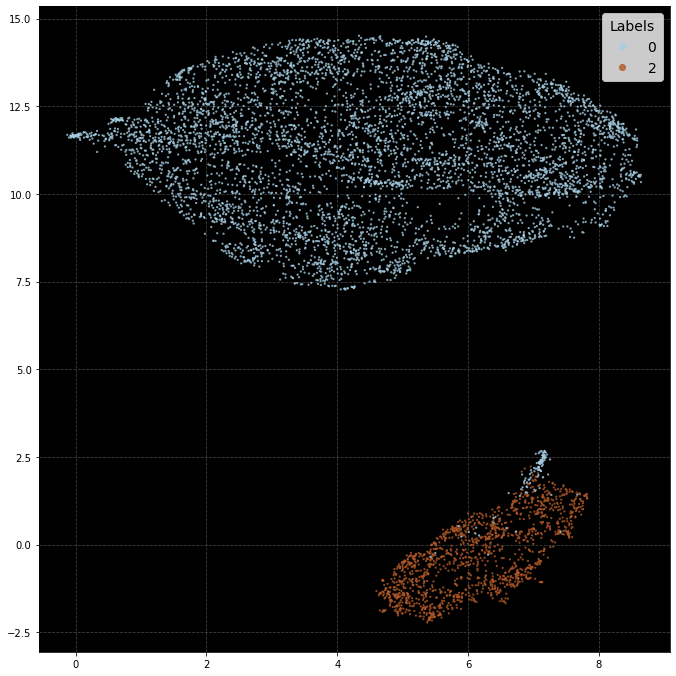

In [ ]:
# plot mapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"/content/drive/MyDrive/PhD/export_data/umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

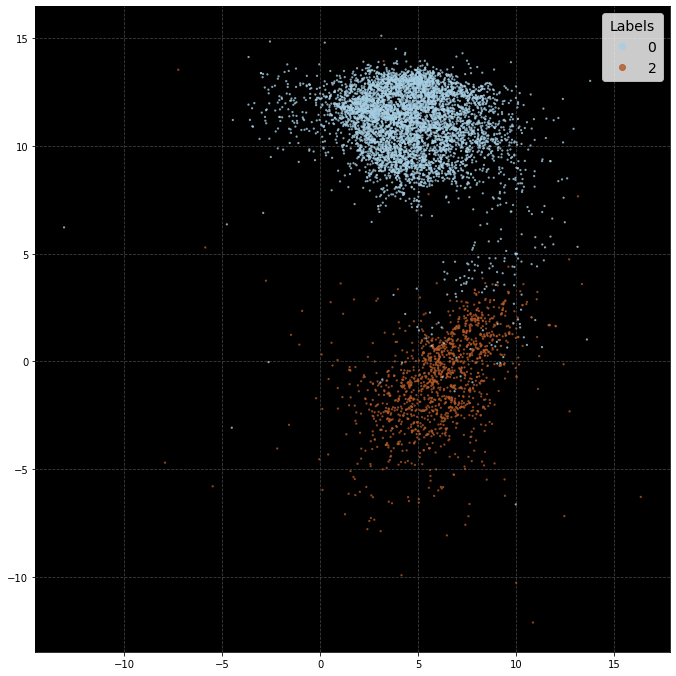

In [ ]:
# plot densmapper embedding
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(dens_mapper.embedding_[:, 1], dens_mapper.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

# plt.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# fig.savefig(f"{export_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

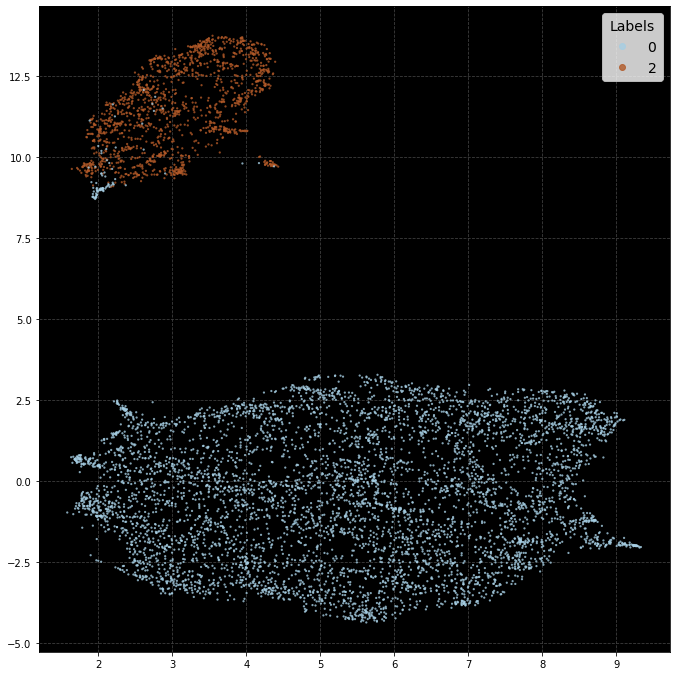

In [ ]:
# plot mapper (gauss)
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(mapper_gauss.embedding_[:, 1], mapper_gauss.embedding_[:, 0], c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", s=5, zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

plt.tight_layout()
plt.show()

# fig.savefig(f"{export_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

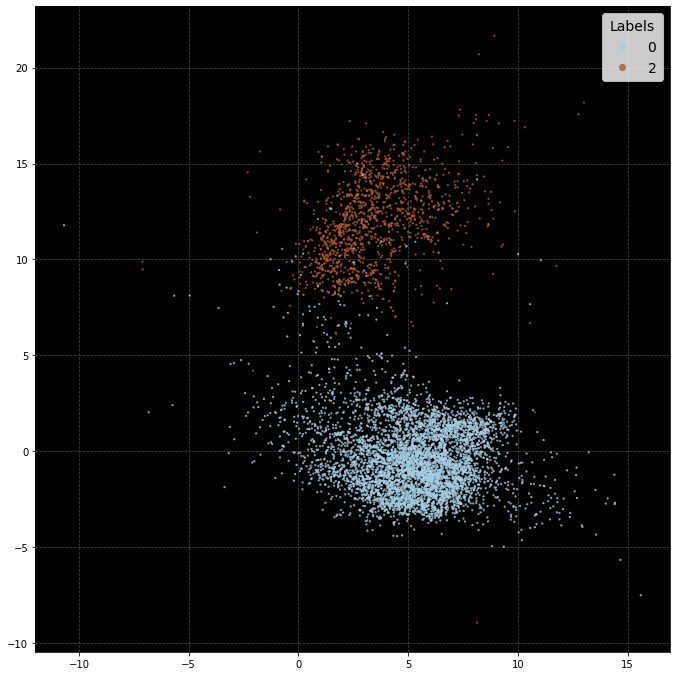

In [ ]:
# plot densmapper (gauss)
fig, ax = plt.subplots(figsize=(9.5, 9.5))

scatter = ax.scatter(dens_mapper_gauss.embedding_[:, 1], dens_mapper_gauss.embedding_[:, 0], 
                     c=test_labels, 
                    #  label=["non-db", "db"], 
                     cmap="Paired", 
                     alpha=0.8, 
                     edgecolors="none", 
                     s=5, 
                     zorder=1)

# ax.set_title("UMAP embedding", fontsize=18)
# ax.legend()
ax.legend(*scatter.legend_elements(), title="Labels", title_fontsize=14, fontsize=14)
ax.set_facecolor('k')
ax.set_axisbelow(True)
ax.grid(color="0.25", linestyle="--")

plt.tight_layout()
plt.show()

# fig.savefig(f"{output_path}umap_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

**superimposing binned images on embedding (like a 2D histogram)**
- in the `MyManifoldProjection` function, you can choose between showing an average image of the bin or showing a single image

In [ ]:
# normalize image values to 0-1 range (Min-Max scaling) & 
# convert to 8-bit for projection on umap
# embed_rois = ((test_rois-np.min(test_rois))/(np.ptp(test_rois)) * 255).astype(np.uint8)
# print(embed_rois.shape)

In [47]:
# define ManifoldProjection instance with specified output shape (default = 64x64)
mapper_projection = MyManifoldProjection2D(test_masked_rois, output_shape=(76, 76))

In [48]:
# get image grid, increase bin number to show more images/granularity
img_grid, heatmap, delimiters = mapper_projection(mapper.embedding_, components=(0,1), bins=32)
img_grid_dens, heatmap_dens, delimiters_dens = mapper_projection(dens_mapper.embedding_, components=(0,1), bins=32)

100%|██████████| 332/332 [00:00<00:00, 3529.74it/s]

(0.42194318771362305, 9.187300682067871, -2.5906472206115723, 14.151564598083496)
(-10.152754783630371, 18.291501998901367, -11.435334205627441, 15.90916919708252)


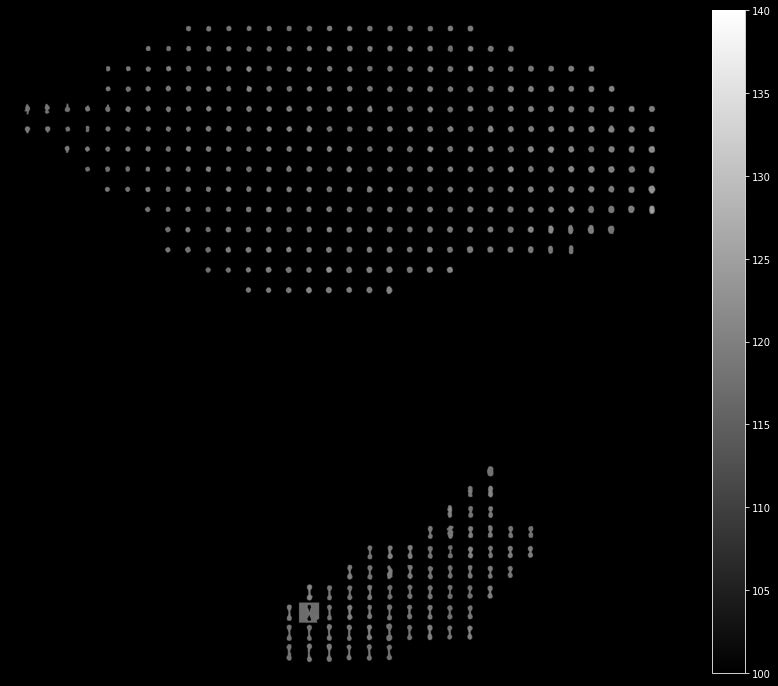

In [51]:
# plot mapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 9.5))

im = plt.imshow(img_grid,
                origin="lower",
                # extent=delimiters, 
                vmin=100, vmax=140, # modify or comment out according to image intensity values to show
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper.embedding_[:, 1], mapper.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()

# fig.savefig(f"{output_path}umap_masked_32bins_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")

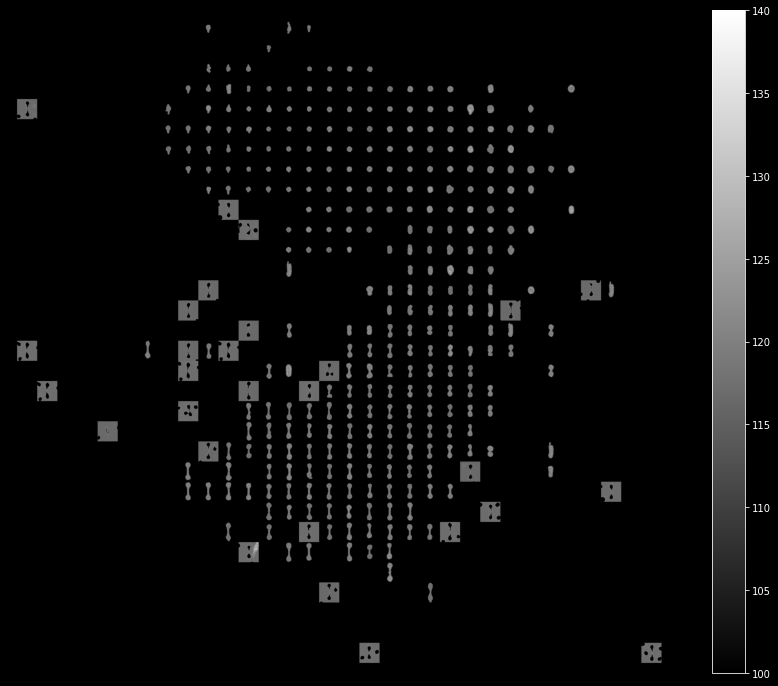

In [52]:
# plot densmapper image projection

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(12, 9.5))

im = plt.imshow(img_grid_dens,
                origin="lower",
                # extent=delimiters, 
                vmin=100, vmax=140, # modify or comment out according to image intensities
                cmap="gray",)

# scatter plot will only show appropriately if `extent` is used in imshow
# scatter = ax.scatter(mapper_dens.embedding_[:, 1], mapper_dens.embedding_[:, 0], c=test_labels, 
#                     #  label=["non-db", "db"], 
#                      cmap="Paired", 
#                     #  alpha=0.3, 
#                      edgecolors="none", 
#                      s=3, 
#                      zorder=2)

plt.axis("off")
plt.tight_layout()
plt.colorbar()

# fig.savefig(f"{output_path}umap_dens_masked_32bins_{mapper.n_neighbors}nbs_rnd{mapper.random_state}.png", 
#             dpi=300, bbox_inches="tight")